Processing trajectories: 100%|██████████| 140000/140000 [00:00<00:00, 1203525.63it/s]


(280, 500, 2)
# of Unique Training Trajectories: 233
[-0.192 -0.96 ]


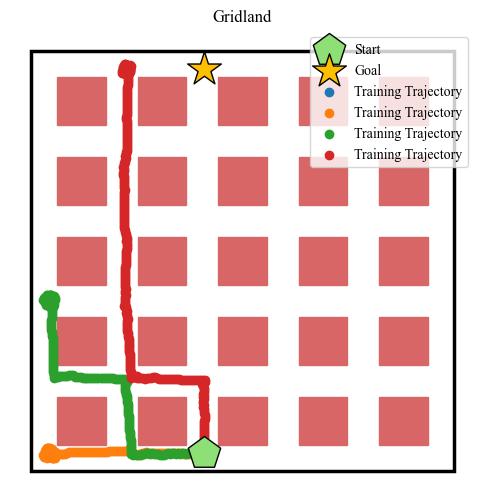

In [14]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from diffusion_planner import DiffusionPlannerConfig
from diffusion_planner import eval_model as diffusion_planer_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.cleandiffuser.classifier import CumRewClassifier
from utilities.cleandiffuser.nn_classifier import HalfJannerUNet1d
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps
plt.rcParams["font.family"] = "Times New Roman"

# start and end goal     # 2,0 -> 2,5 should be a novel S-A pair
start_idx = (2,0)
goal_idx = (2,5)


#(2, 0) (2, 5)
env = 'gridland'
n_size = 5
memory = 1
horizon = 512 # for generation so must be power of 2
num_envs = 50
num_episodes = 1
temperature = 0.5
n_exec_steps = 512
render = True
goal_inpaint_steps = 25

# gets the set of trajectories from the training data 
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs,goal_cond=True)
env = GridLand(n_size=5,timeout = 500)
 
env.reset(start_idx=start_idx,goal_idx=goal_idx)
train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
batch = train_dataset.sample(idxs=range(280))
#batch = train_dataset.sample()
print(batch['observations'].shape)
traj_visitations = []
for trajectory in batch['observations']:
    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
    traj_visitations.append(visited_intersections_idx)
    #print(trajectory)
training_trajectory_visitations = get_trajectory_sets(traj_visitations)
print('# of Unique Training Trajectories:',len(training_trajectory_visitations))

env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
print(env.start)
fig, ax = env.get_mpl_plot()
for trajectory,traj_idx in zip(batch['observations'],traj_visitations):
    if np.linalg.norm(trajectory[0,:] - env.start) < 0.1:
        #print(trajectory.shape)
        ax.scatter(trajectory[:,0],trajectory[:,1],label = 'Training Trajectory')
ax.legend()

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Avg. Completion: 0.12
# of Training Trajectory Repeats 16
# of Unique Generated Trajectories: 23
# of New Generated Trajectories: 21
% of Generated Trajectories Novel: 0.9130434782608695
# of Unique Generated Successful Trajectories: 5


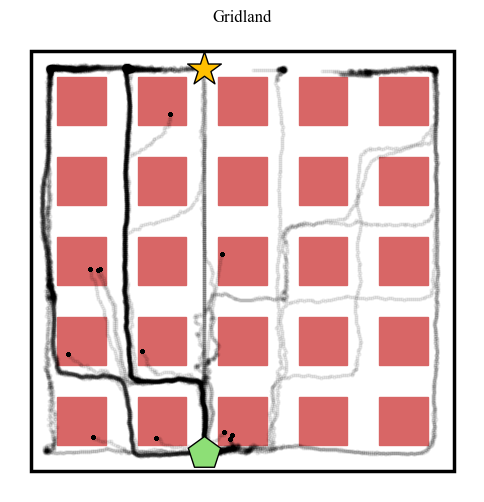

In [17]:
### Eq-Net + PosEnc
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = True
config.goal_inpaint_steps = goal_inpaint_steps
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = 512
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'none'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = True
config.add_positional_encoding = True


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position=config.add_positional_encoding)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_150000.pt') # should be a quite decent model
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_250000.pt') # decent model at 250000
#agent.load('trained_models/DP-EqNet-PosEnc-gridland-n5-gc-c5dec87ediffusion_ckpt_latest.pt') # v1 w/positional attention at 250000
#agent.load('trained_models/DP-EqNet-SinPosEnc-gridland-n5-gc-9a5b6af0diffusion_ckpt_latest.pt') # v2 w/positional attention at 250000

#agent.load('trained_models/DP-EqNet-Short-Sample-gridland-n5-gc-e66dc18fdiffusion_ckpt_latest.pt') # one trained on subsequences 1m steps

#agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-6a5a1a58diffusion_ckpt_500000.pt')
#agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-c0fec9bfdiffusion_ckpt_500000.pt')

agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-gc-d36c72a4diffusion_ckpt_latest.pt')
# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#print('replans',np.array(replans).shape)
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
if num_envs == 1:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='#e68d35',s=20,label='Executed Trajectory',alpha=1,zorder=100)
else:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
#ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


if num_envs == 1 and n_exec_steps != 512:
        replan_colors = colormaps['plasma_r']
        gradient = np.linspace(0, 1, len(replans[0]))
        for i,replan in enumerate(replans[0]):
                #print(replan.shape)
                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

#print(trajectories[0].shape)
        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
#print(visited_intersections.shape)
        #ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
#ax.legend()
fig.set_dpi(100)

traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
reproduced_training_trajectories = 0
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
                # stuff
                this_trajectory_set = get_trajectory_sets([visited_intersections_idx])
                if len(this_trajectory_set & training_trajectory_visitations) !=0:
                        reproduced_training_trajectories += 1
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)
print('# of Training Trajectory Repeats',reproduced_training_trajectories)
print('# of Unique Generated Trajectories:',len(generated_trajectory_visitations))
print('# of New Generated Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
#print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
#print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

5
5


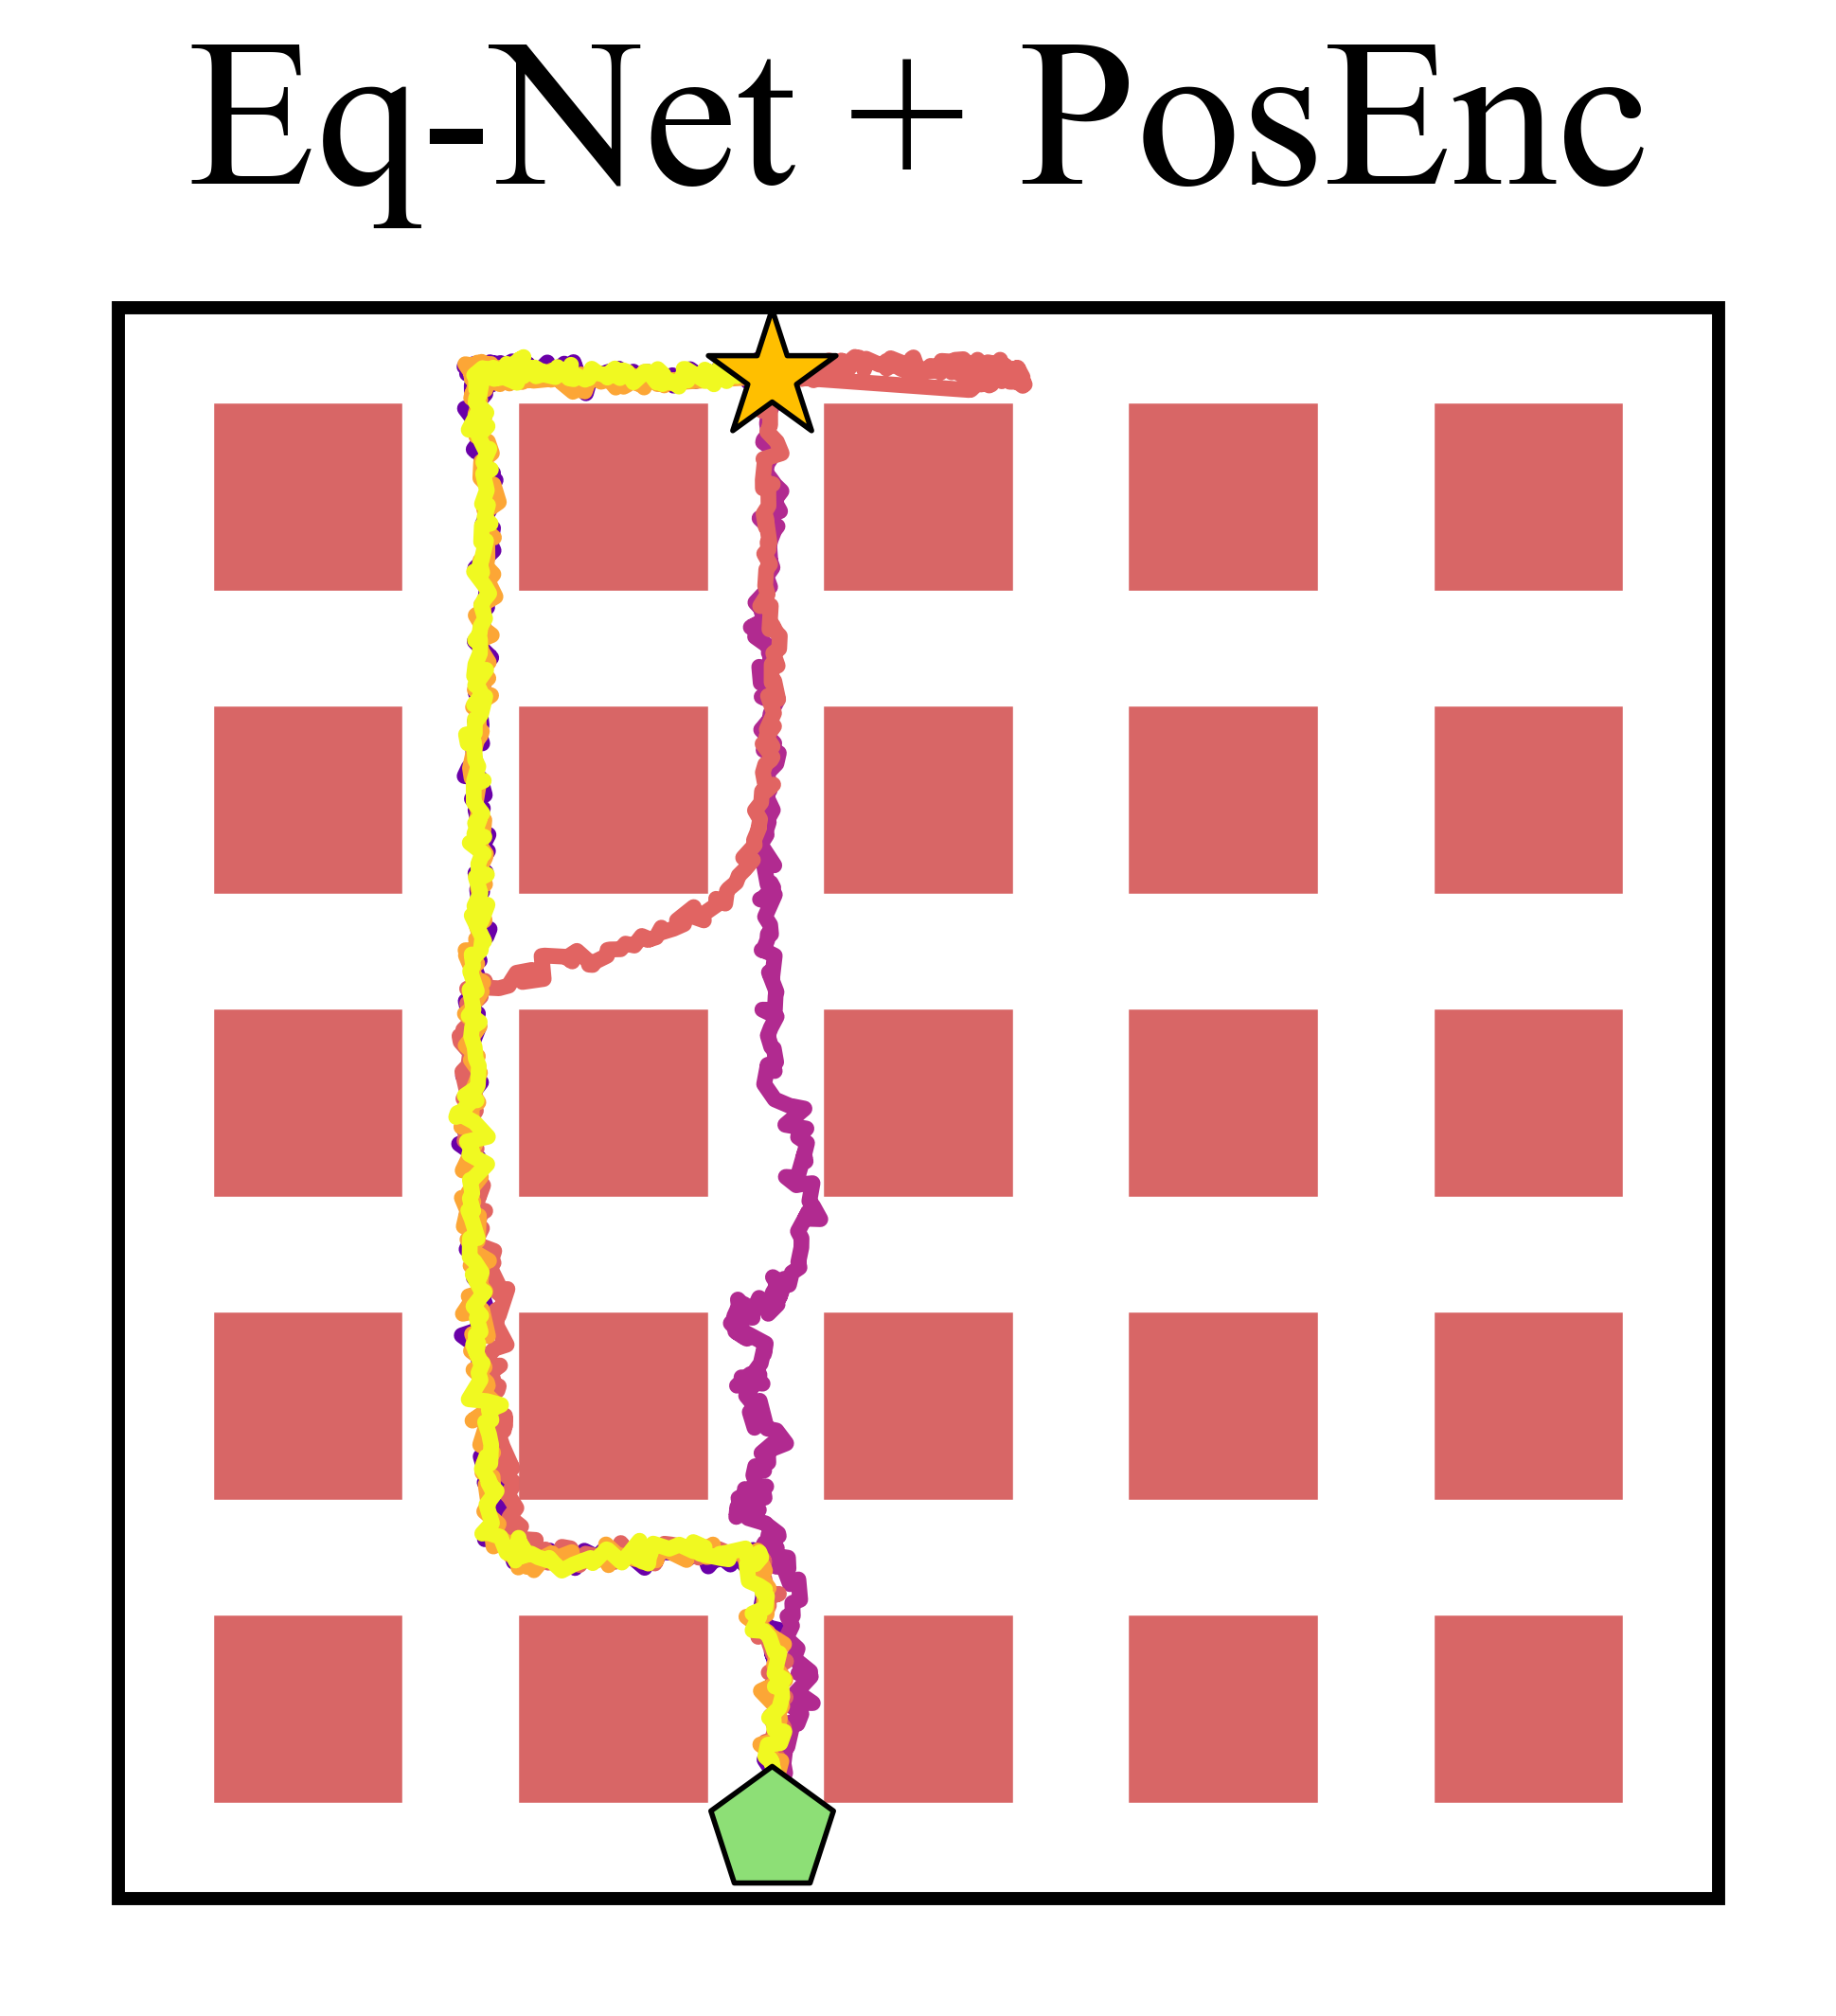

In [18]:
# looking at trajectories and plans for novel ones generated zero shot

novel_plans_raw = []
novel_trajectories_raw = []
seen_novel = []
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Eq-Net + PosEnc',fontsize=40)
novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in novel_trajectories and visited_intersections_idx not in seen_novel:
                        ax.plot(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),label='Plan' + str(i),zorder=10-i,linewidth=3,)
                        color_index += 1/len(novel_trajectories)
                        novel_plans_raw.append(replans[i,0,:,:])
                        novel_trajectories_raw.append(trajectory)
                        seen_novel.append(visited_intersections_idx)
print(len(novel_trajectories))
print(len(novel_trajectories_raw))
fig.dpi = 400

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


Avg. Completion: 0.92
# of Training Trajectory Repeats 1
# of Unique Generated Trajectories: 35
# of New Generated Trajectories: 34
% of Generated Trajectories Novel: 0.9714285714285714
# of Unique Generated Successful Trajectories: 32


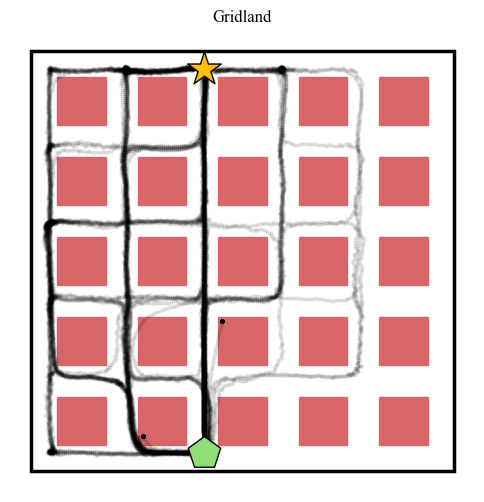

In [19]:
### Eq-Net, Unconditional
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = True
config.goal_inpaint_steps = goal_inpaint_steps
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = 512
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'none'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = True
config.add_positional_encoding = False


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position=config.add_positional_encoding)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_150000.pt') # should be a quite decent model
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-15fe4eb0diffusion_ckpt_250000.pt') # decent model at 250000
#agent.load('trained_models/DP-EqNet-PosEnc-gridland-n5-gc-c5dec87ediffusion_ckpt_latest.pt') # v1 w/positional attention at 250000
#agent.load('trained_models/DP-EqNet-SinPosEnc-gridland-n5-gc-9a5b6af0diffusion_ckpt_latest.pt') # v2 w/positional attention at 250000

#agent.load('trained_models/DP-EqNet-Short-Sample-gridland-n5-gc-e66dc18fdiffusion_ckpt_latest.pt') # one trained on subsequences 1m steps

#agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-6a5a1a58diffusion_ckpt_500000.pt')
#agent.load('trained_models/DP-UNet-pointmaze-giant-navigate-v0-c0fec9bfdiffusion_ckpt_500000.pt')

agent.load('paper_models/DP-EqNet-gridland-n5-gc-9f810216diffusion_ckpt_latest.pt')
# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#print('replans',np.array(replans).shape)
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
if num_envs == 1:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='#e68d35',s=20,label='Executed Trajectory',alpha=1,zorder=100)
else:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
#ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


if num_envs == 1 and n_exec_steps != 512:
        replan_colors = colormaps['plasma_r']
        gradient = np.linspace(0, 1, len(replans[0]))
        for i,replan in enumerate(replans[0]):
                #print(replan.shape)
                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

#print(trajectories[0].shape)
        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
#print(visited_intersections.shape)
        #ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
#ax.legend()
fig.set_dpi(100)

traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
reproduced_training_trajectories = 0
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
                # stuff
                this_trajectory_set = get_trajectory_sets([visited_intersections_idx])
                if len(this_trajectory_set & training_trajectory_visitations) !=0:
                        reproduced_training_trajectories += 1
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)
print('# of Training Trajectory Repeats',reproduced_training_trajectories)
print('# of Unique Generated Trajectories:',len(generated_trajectory_visitations))
print('# of New Generated Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
#print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
#print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

32
32


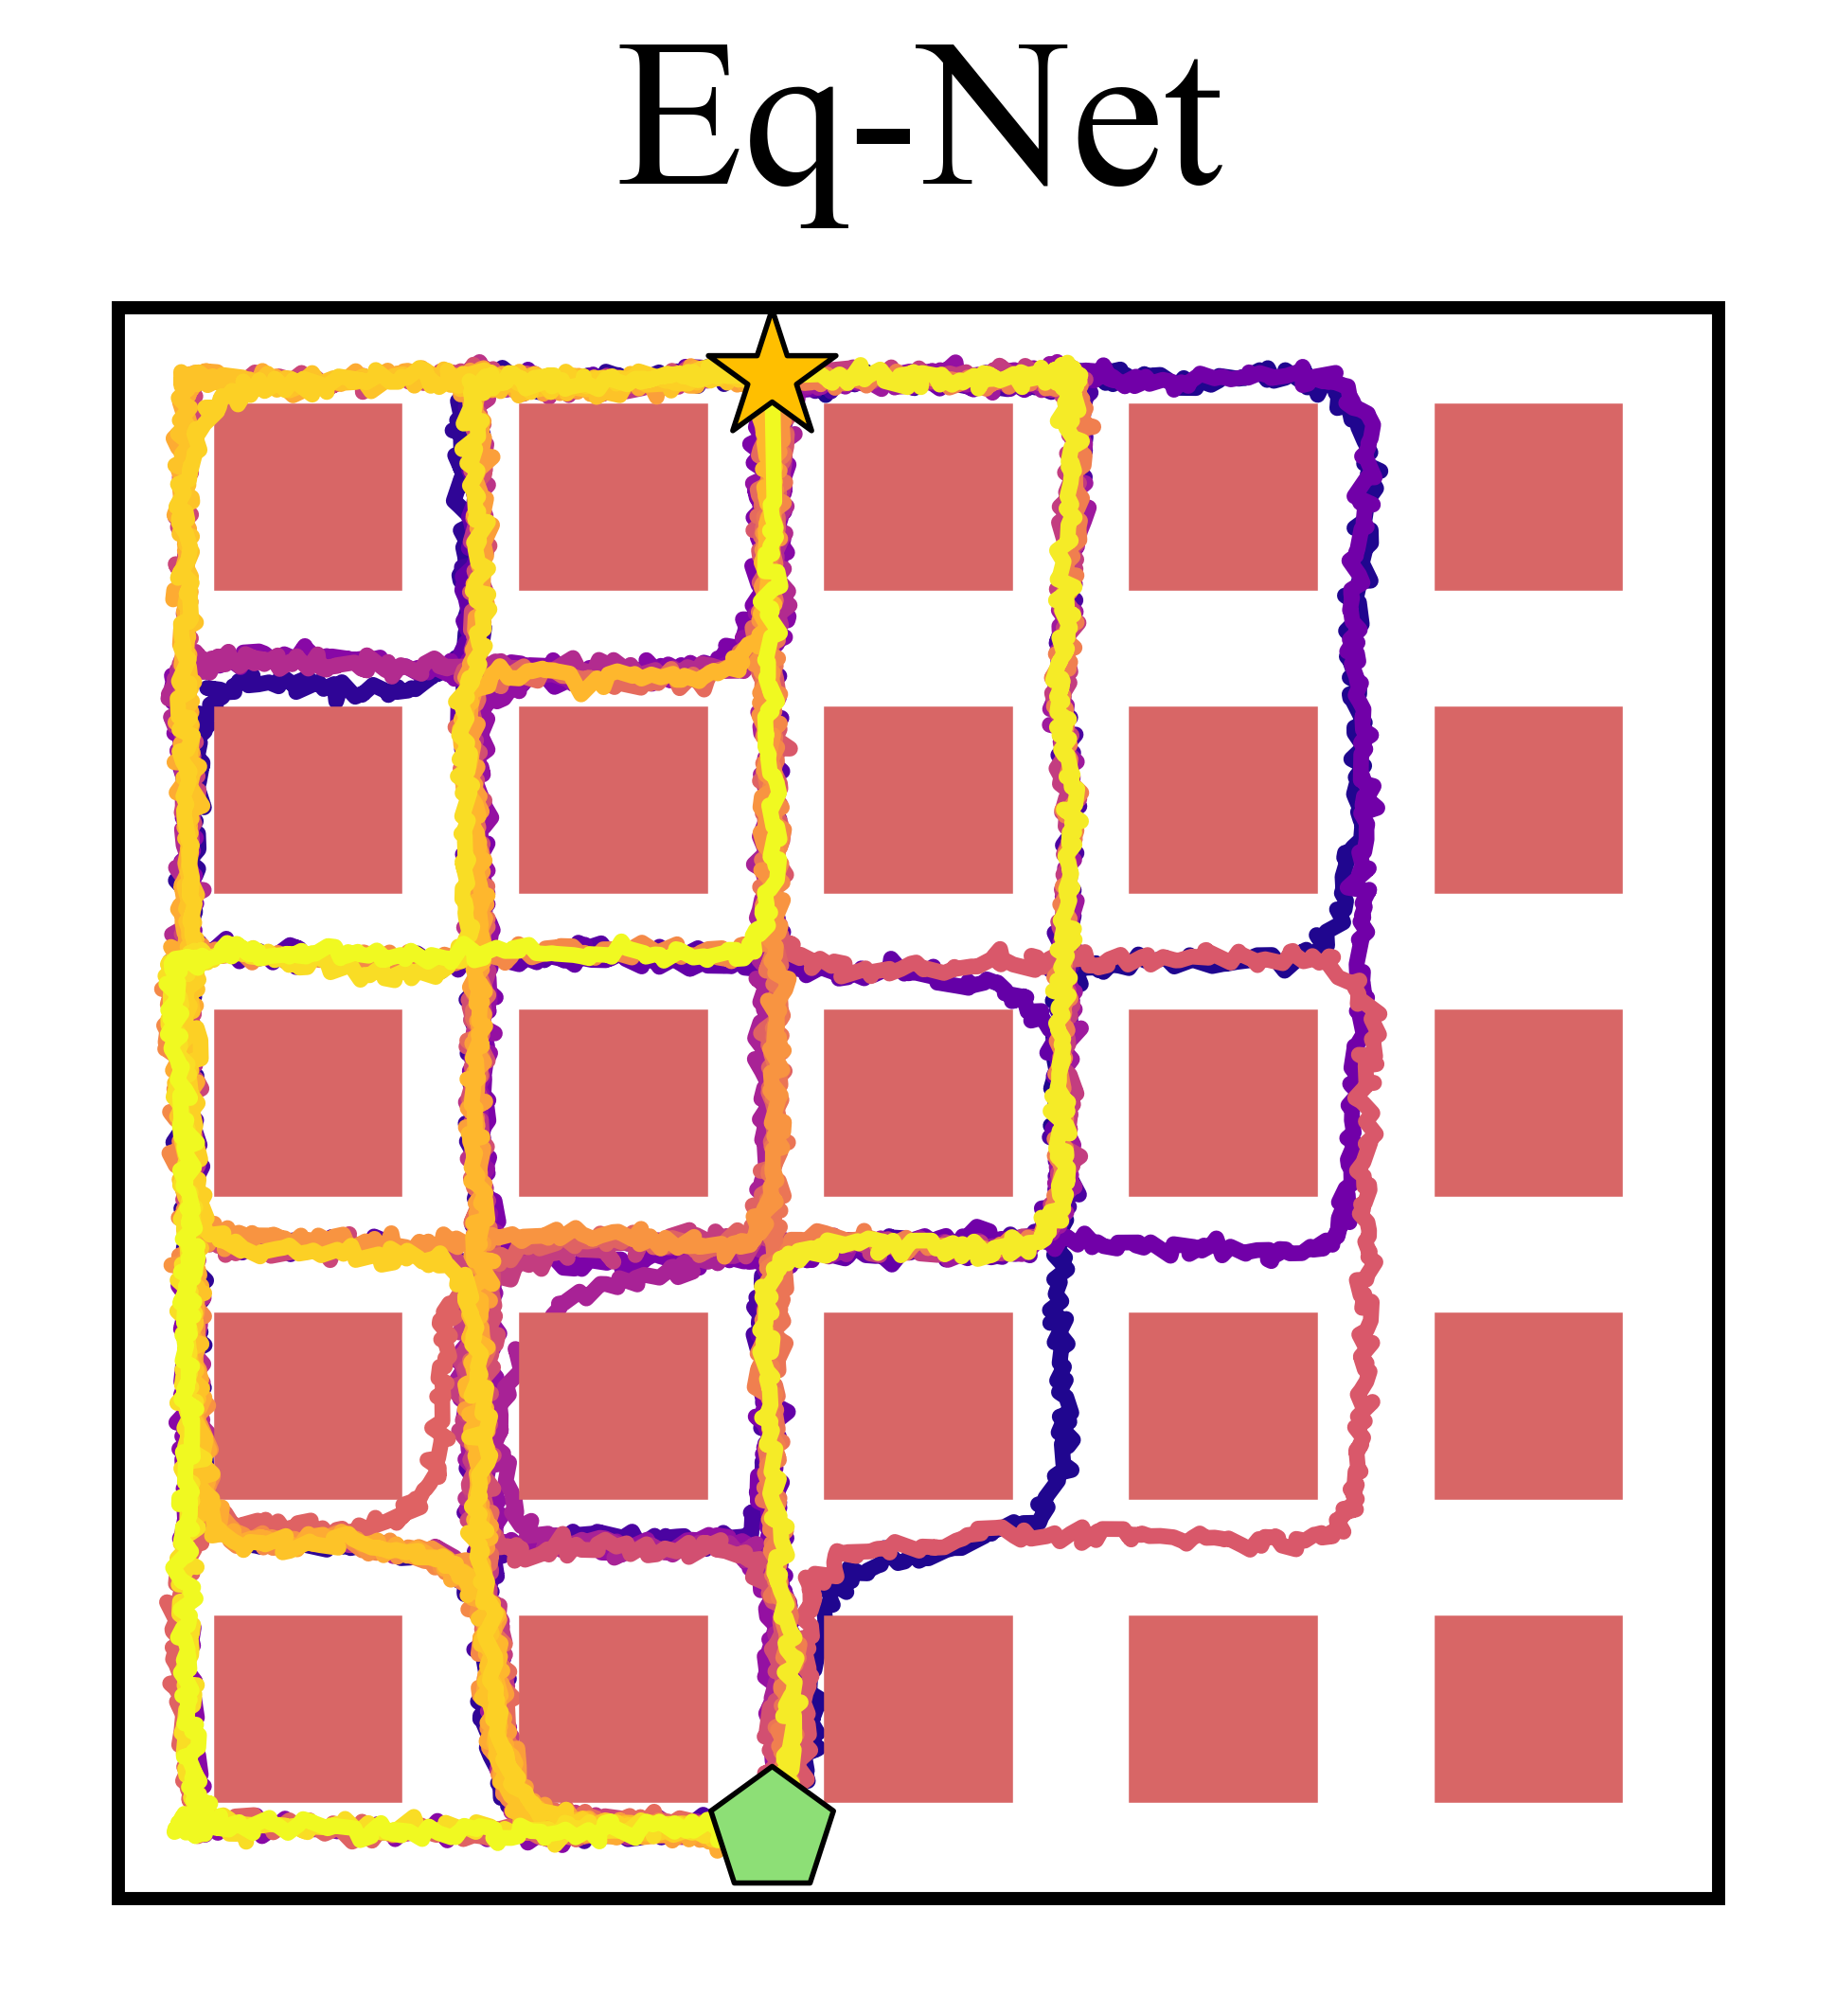

In [20]:
# looking at trajectories and plans for novel ones generated zero shot
novel_plans_raw = []
novel_trajectories_raw = []
seen_novel = []
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Eq-Net',fontsize=40)
novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in novel_trajectories and visited_intersections_idx not in seen_novel:
                        ax.plot(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),label='Plan' + str(i),zorder=10-i,linewidth=3,)
                        color_index += 1/len(novel_trajectories)
                        novel_plans_raw.append(replans[i,0,:,:])
                        novel_trajectories_raw.append(trajectory)
                        seen_novel.append(visited_intersections_idx)
print(len(novel_trajectories))
print(len(novel_trajectories_raw))
fig.dpi = 400

frozenset({(0, 1), (0, 4), (2, 1), (1, 5), (1, 1), (0, 3), (2, 0), (0, 2), (0, 5), (2, 2), (1, 0), (2, 5)})


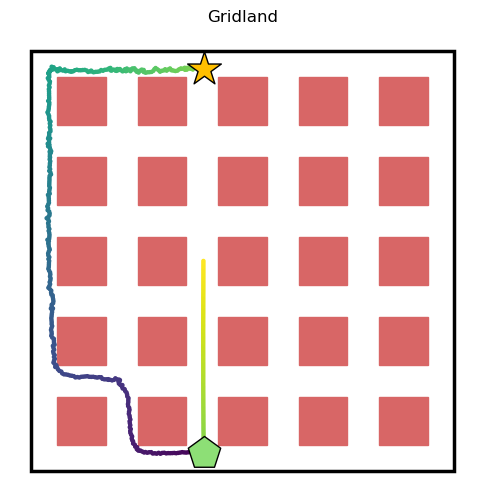

In [132]:
# go through replans individually
# looking at trajectories and plans for novel ones generated zero shot
#i = 0
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#ax.scatter(novel_plans_raw[i][:,0],novel_plans_raw[i][:,1],c=range(len(replans[i,0,:,0])),s=5,label='Plan' + str(i),zorder=1000000)
ax.scatter(novel_trajectories_raw[i][:,0],novel_trajectories_raw[i][:,1],c=range(len(novel_trajectories_raw[i][:,0])),s=5,label='Plan' + str(i),zorder=1000000)
#ax.scatter(novel_plans_raw[i][:,0],novel_plans_raw[i][:,1],c='blue',s=5,label='Plan' + str(i),zorder=1000000)

print(seen_novel[i])
i+=1

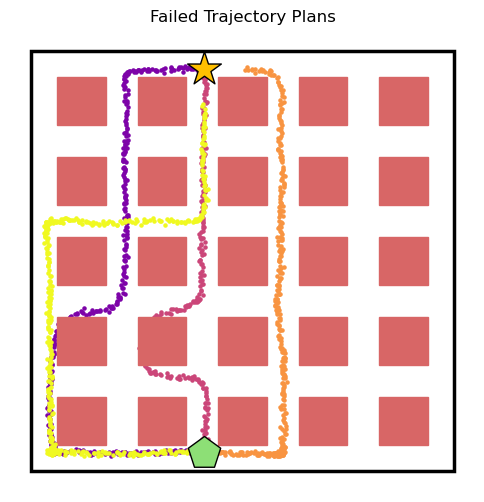

In [6]:
# looking at teailures
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Failed Trajectory Plans')
failed_trajectories = generated_trajectory_visitations - (filtered_trajectories | training_trajectory_visitations)
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in failed_trajectories:
                        ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                        color_index += 1/len(failed_trajectories)
                        

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


Avg. Completion: 0.0
# of Unique Generated Successful Trajectories: 3
# of New Generated Succesful Trajectories: 0
% of Generated Succesful Trajectories Novel: 0.0
# of Unique Generated Successful Trajectories: 0
# of New Generated Succesful Trajectories: 0


ZeroDivisionError: division by zero

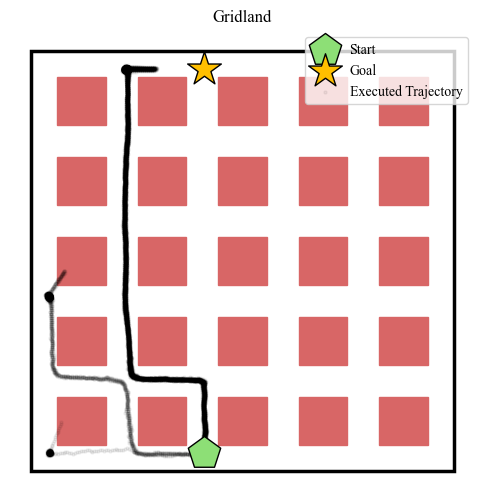

In [21]:
### U-Net, Unconditional
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = True
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'none'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = False
config.goal_inpaint_steps = goal_inpaint_steps


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')

# one trained on full sequences
#agent.load('trained_models/DP-UNet-Uncond-gridland-n5-gc-fea107a9diffusion_ckpt_150000.pt')
# one trained on subsequences
#agent.load('trained_models/DP-UNet-SubSeqTrain-Uncond-gridland-n5-gc-a69f3749diffusion_ckpt_latest.pt')

agent.load('paper_models/DP-UNet-gridland-n5-gc-fed50478diffusion_ckpt_latest.pt')

# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#print('replans',np.array(replans).shape)
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
if num_envs == 1:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
else:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
#ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


if num_envs == 1:
        replan_colors = colormaps['plasma_r']
        gradient = np.linspace(0, 1, len(replans[0]))
        for i,replan in enumerate(replans[0]):
                #print(replan.shape)
                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

#print(trajectories[0].shape)
        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
#print(visited_intersections.shape)
        ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)

print('# of Unique Generated Successful Trajectories:',len(generated_trajectory_visitations))
print('# of New Generated Succesful Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

0
0


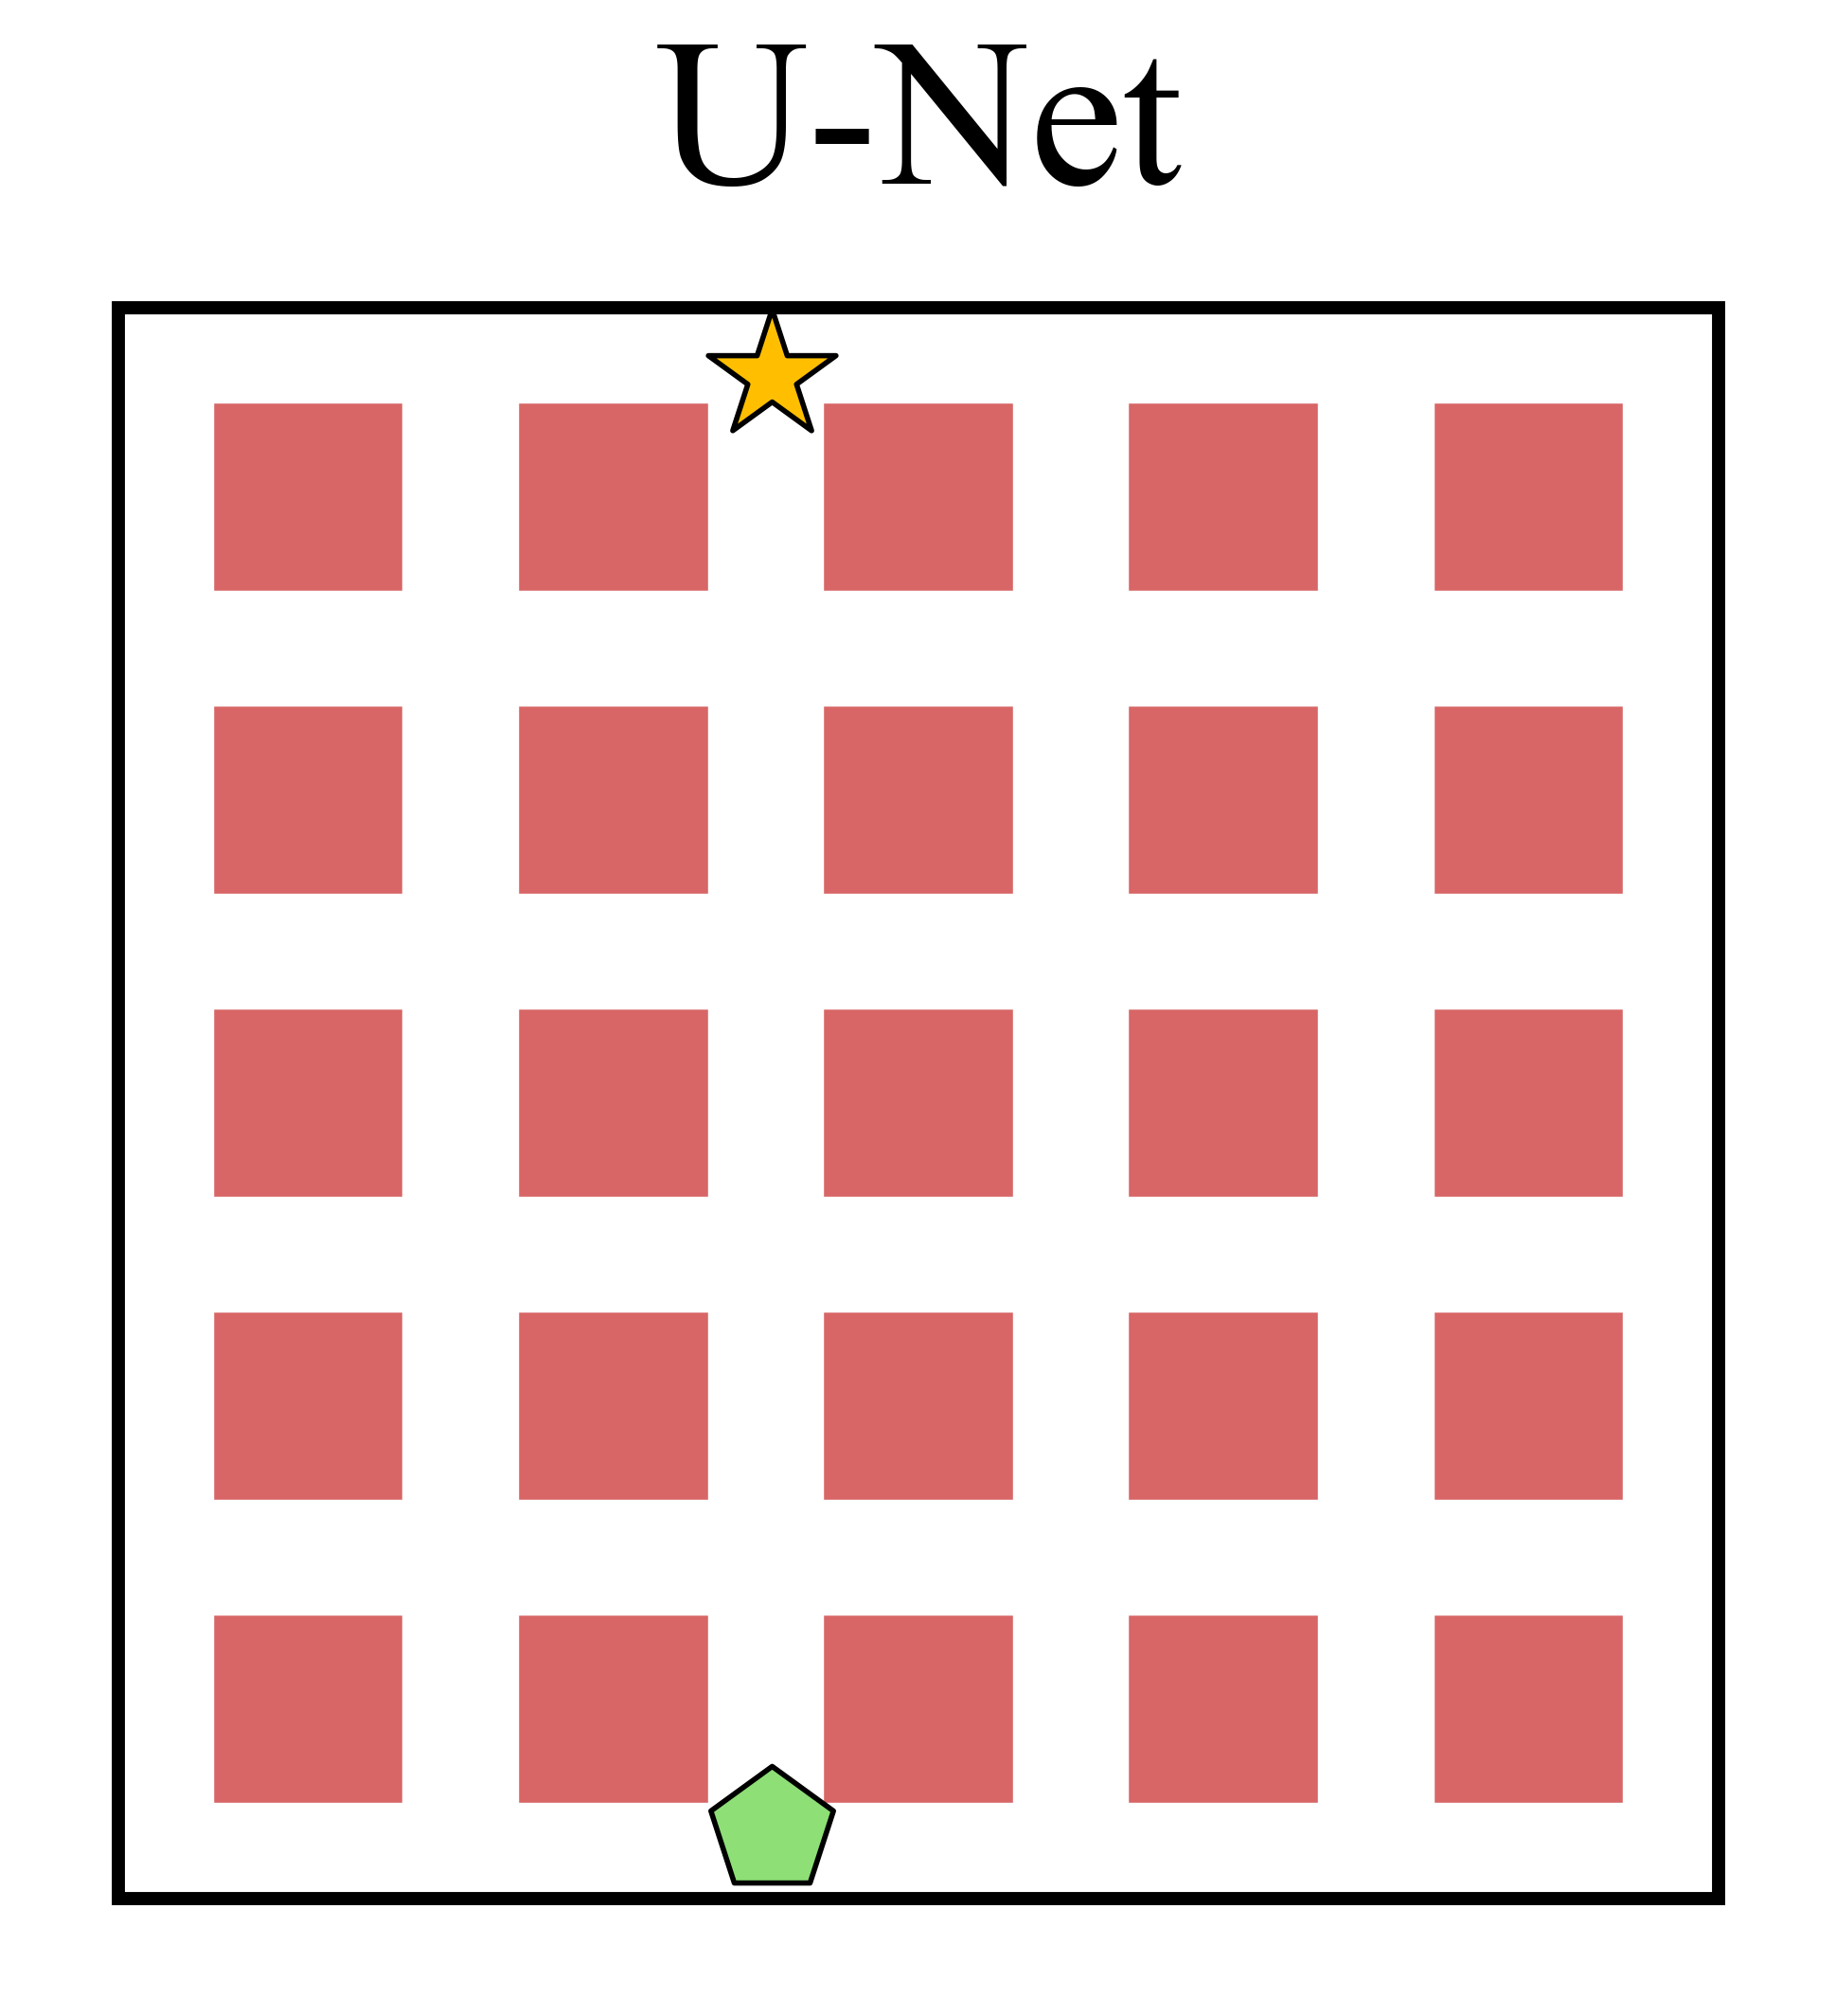

In [22]:
# looking at trajectories and plans for novel ones generated zero shot
novel_plans_raw = []
novel_trajectories_raw = []
seen_novel = []
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('U-Net',fontsize=40)
novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in novel_trajectories and visited_intersections_idx not in seen_novel:
                        ax.plot(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),label='Plan' + str(i),zorder=10-i,linewidth=3,)
                        color_index += 1/len(novel_trajectories)
                        novel_plans_raw.append(replans[i,0,:,:])
                        novel_trajectories_raw.append(trajectory)
                        seen_novel.append(visited_intersections_idx)
print(len(novel_trajectories))
print(len(novel_trajectories_raw))
fig.dpi = 400

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Avg. Completion: 0.02
# of Unique Generated Successful Trajectories: 12
# of New Generated Succesful Trajectories: 10
% of Generated Succesful Trajectories Novel: 0.8333333333333334
# of Unique Generated Successful Trajectories: 1
# of New Generated Succesful Trajectories: 1
% of Generated Succesful Trajectories Novel: 1.0


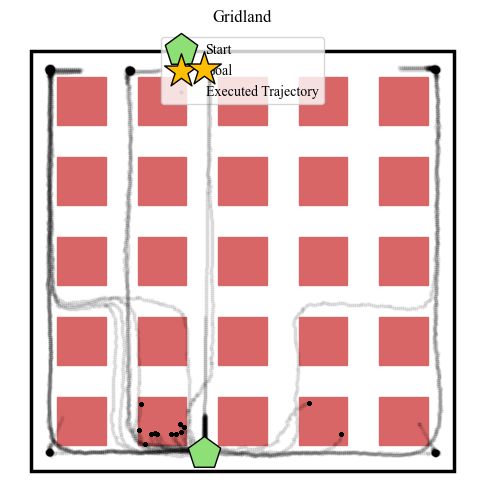

In [33]:
### U-Net + aug 
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = True
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'none'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = False
config.goal_inpaint_steps = goal_inpaint_steps


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')

# one trained on full sequences
#agent.load('trained_models/DP-UNet-Uncond-gridland-n5-gc-fea107a9diffusion_ckpt_150000.pt')
# one trained on subsequences
#agent.load('trained_models/DP-UNet-SubSeqTrain-Uncond-gridland-n5-gc-a69f3749diffusion_ckpt_latest.pt')

agent.load('paper_models/DP-UNet-PosAug-gridland-n5-gc-682c1254diffusion_ckpt_latest.pt')

# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#print('replans',np.array(replans).shape)
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
if num_envs == 1:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
else:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
#ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


if num_envs == 1:
        replan_colors = colormaps['plasma_r']
        gradient = np.linspace(0, 1, len(replans[0]))
        for i,replan in enumerate(replans[0]):
                #print(replan.shape)
                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

#print(trajectories[0].shape)
        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
#print(visited_intersections.shape)
        ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)

print('# of Unique Generated Successful Trajectories:',len(generated_trajectory_visitations))
print('# of New Generated Succesful Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

1
1


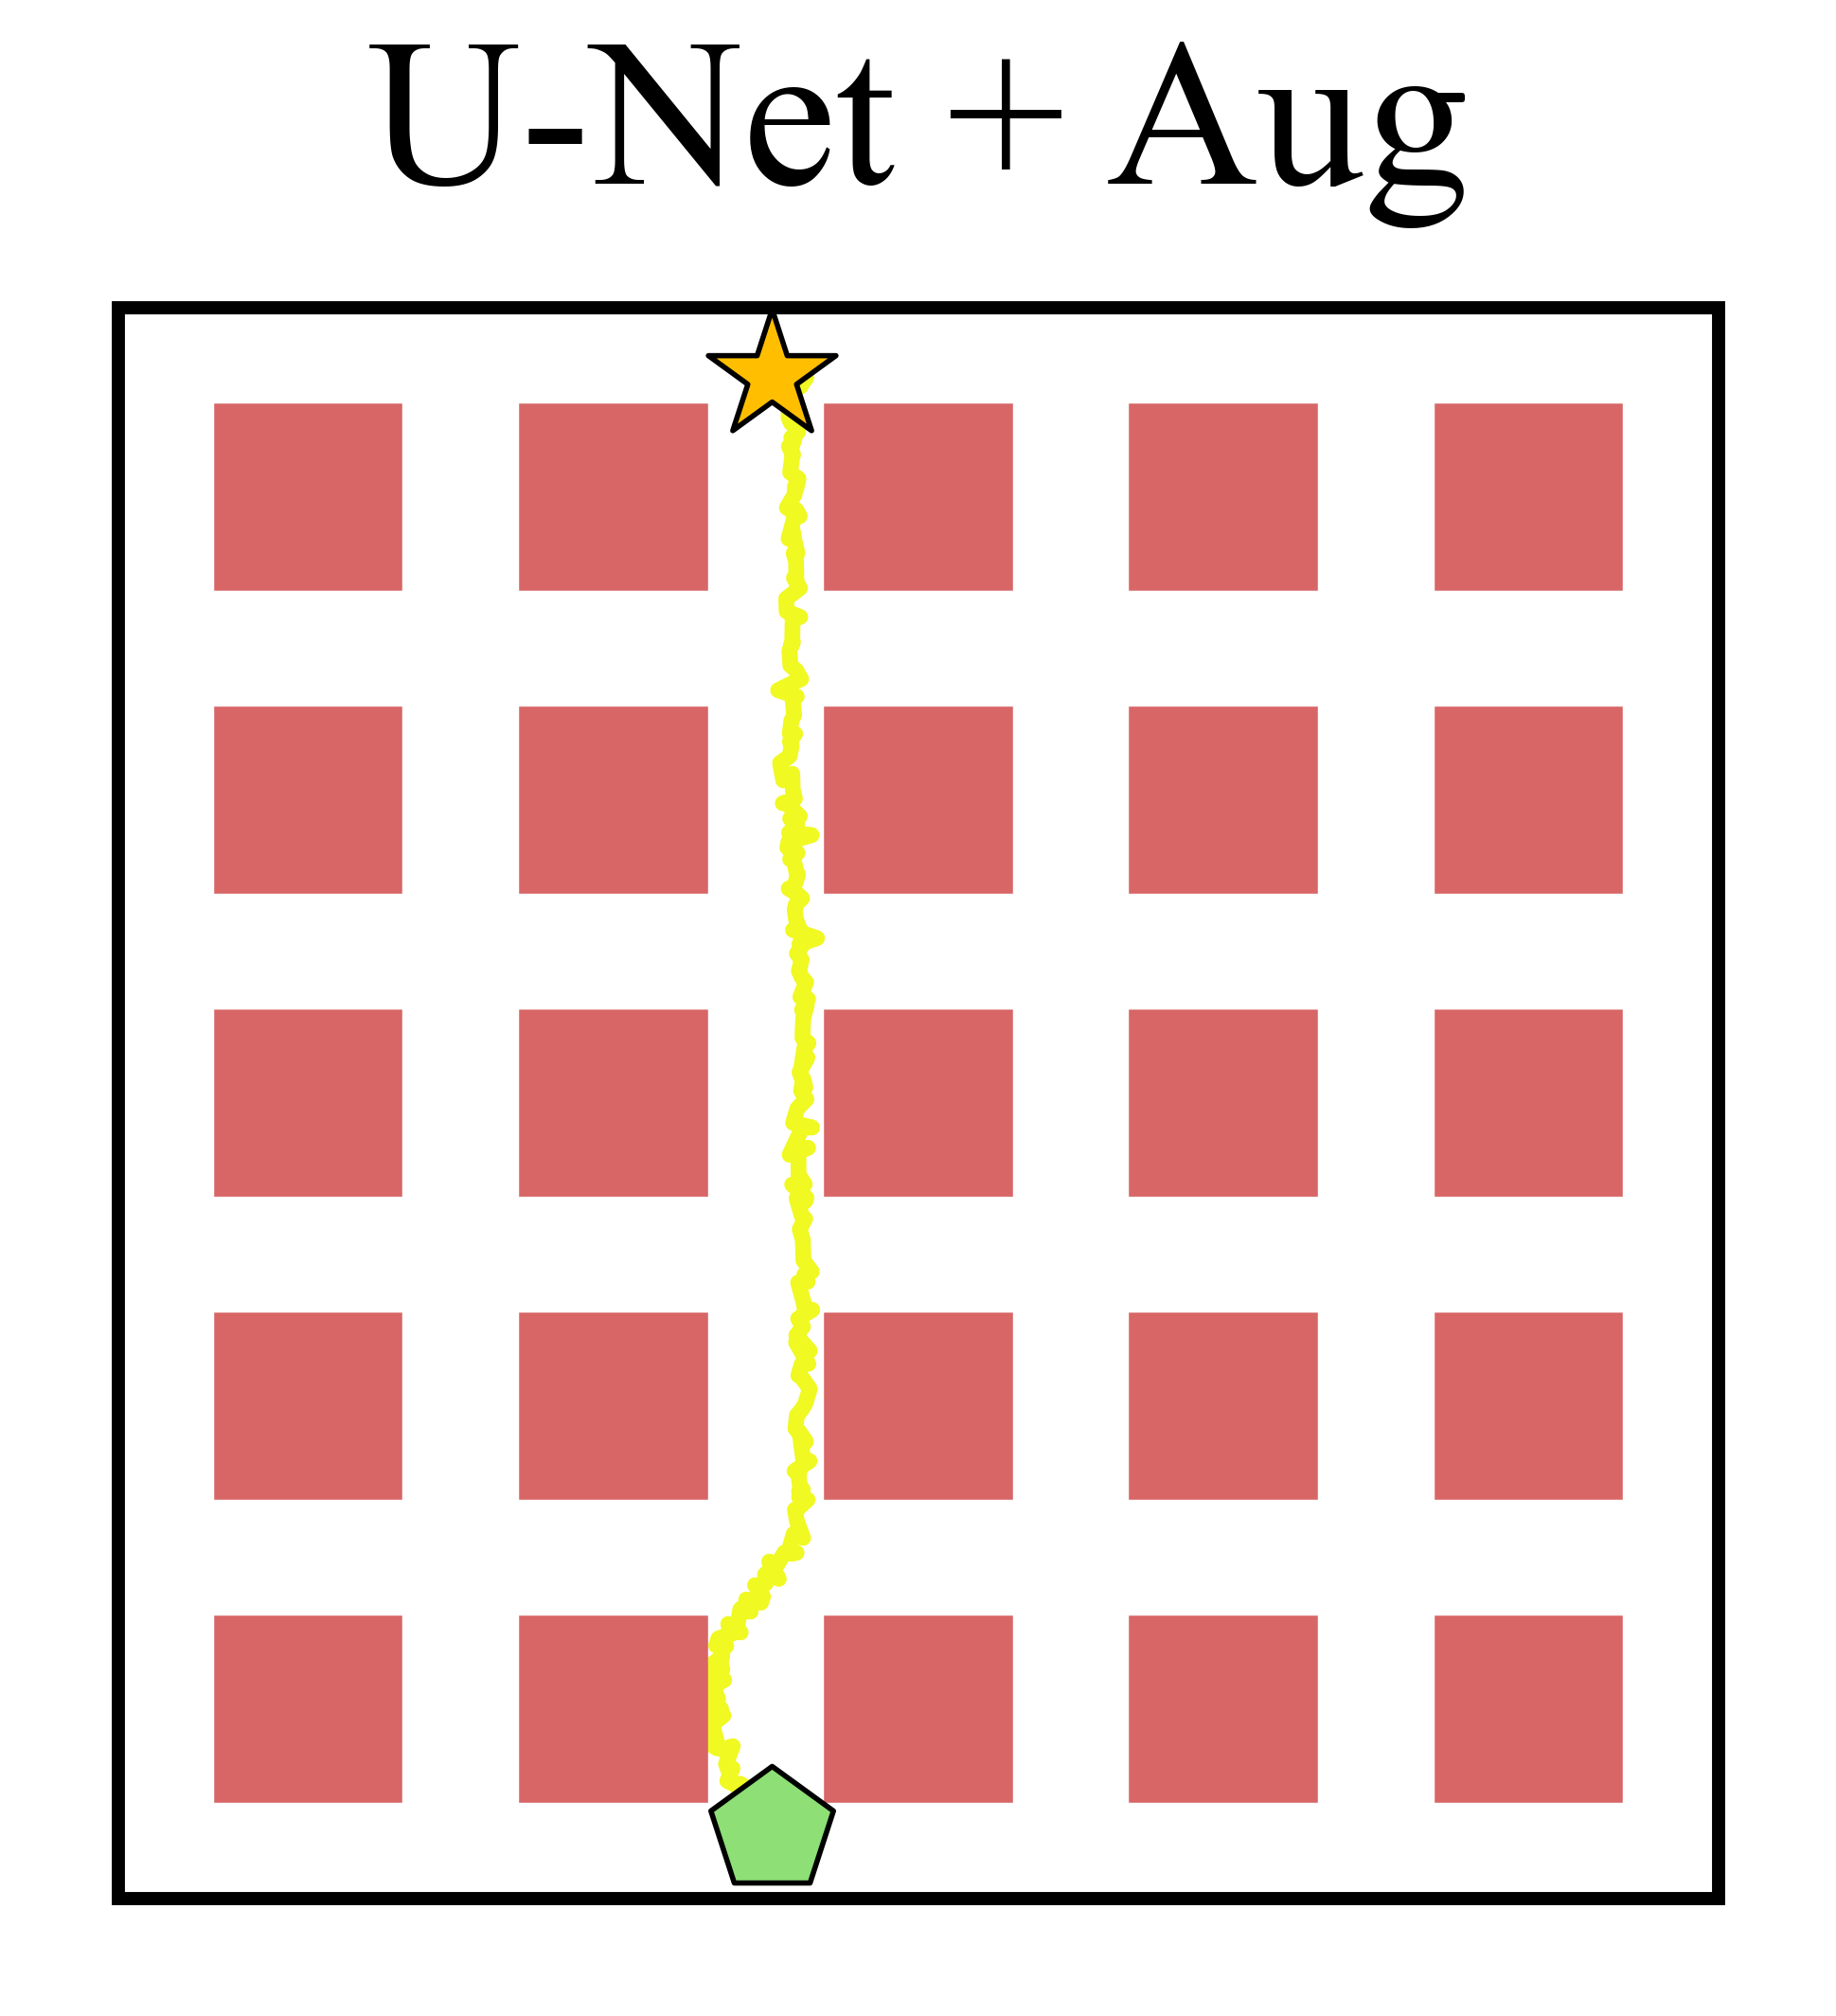

In [34]:
# looking at trajectories and plans for novel ones generated zero shot
novel_plans_raw = []
novel_trajectories_raw = []
seen_novel = []
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('U-Net + Aug',fontsize=40)
novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in novel_trajectories and visited_intersections_idx not in seen_novel:
                        ax.plot(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),label='Plan' + str(i),zorder=10-i,linewidth=3,)
                        color_index += 1/len(novel_trajectories)
                        novel_plans_raw.append(replans[i,0,:,:])
                        novel_trajectories_raw.append(trajectory)
                        seen_novel.append(visited_intersections_idx)
print(len(novel_trajectories))
print(len(novel_trajectories_raw))
fig.dpi = 400

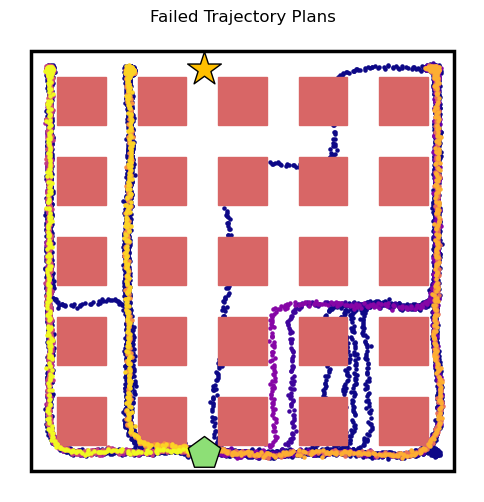

In [10]:
# looking at teailures
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Failed Trajectory Plans')
failed_trajectories = generated_trajectory_visitations - (filtered_trajectories | training_trajectory_visitations)
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in failed_trajectories:
                        ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                        color_index += 1/len(failed_trajectories)
                        

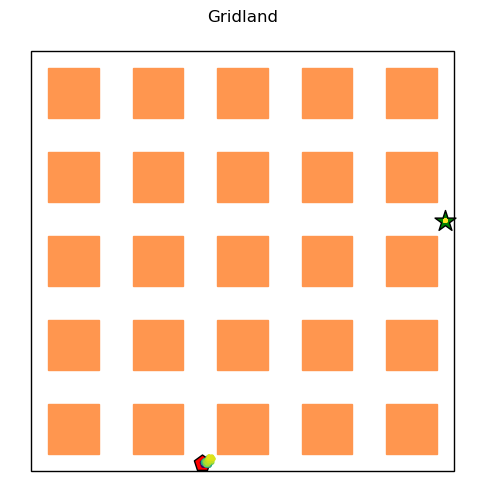

In [30]:
# go through replans individually
# looking at trajectories and plans for novel ones generated zero shot
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.scatter(replans[i,0,:,0],replans[i,0,:,1],c=range(len(replans[i,0,:,0])),s=5,label='Plan' + str(i),zorder=1000000)
i+=1

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:14<00:00, 14.42s/it]


Avg. Completion: 0.024
# of Unique Generated Successful Trajectories: 54
# of New Generated Succesful Trajectories: 52
% of Generated Succesful Trajectories Novel: 0.9629629629629629
# of Unique Generated Successful Trajectories: 4
# of New Generated Succesful Trajectories: 4
% of Generated Succesful Trajectories Novel: 1.0


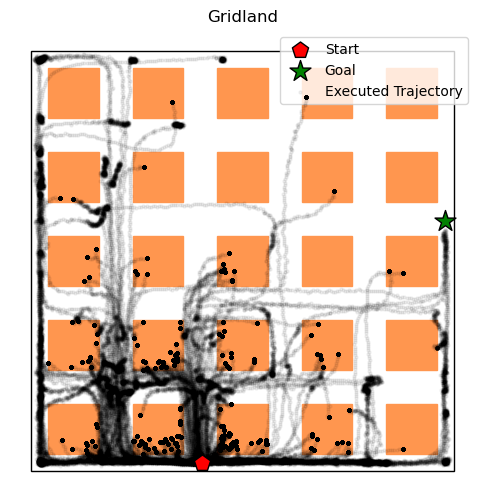

In [13]:
### EqNet, CFG
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'cfg'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = True


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-CFG-gridland-n5-gc-26869e32diffusion_ckpt_150000.pt') # one trained w/end goal sampling
agent.load('trained_models/DP-EqNet-CFG-GoalSubsampling-gridland-n5-gc-1e20e957diffusion_ckpt_250000.pt') # one trained w/subgoal sampling


# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#print('replans',np.array(replans).shape)
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
if num_envs == 1:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
else:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
#ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


if num_envs == 1:
        replan_colors = colormaps['plasma_r']
        gradient = np.linspace(0, 1, len(replans[0]))
        for i,replan in enumerate(replans[0]):
                #print(replan.shape)
                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

#print(trajectories[0].shape)
        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
#print(visited_intersections.shape)
        ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)

print('# of Unique Generated Successful Trajectories:',len(generated_trajectory_visitations))
print('# of New Generated Succesful Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

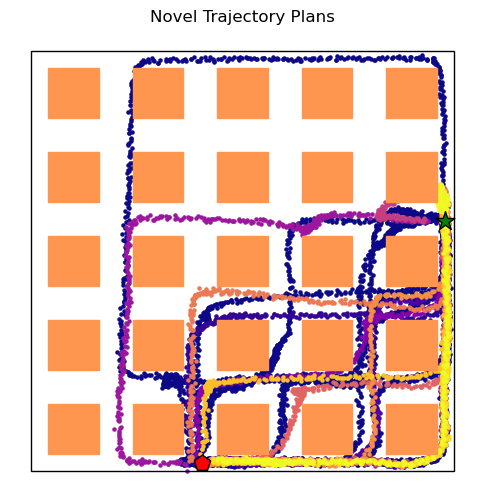

In [23]:
# looking at trajectories and plans for novel ones generated zero shot
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Novel Trajectory Plans')
novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in novel_trajectories:
                        ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                        color_index += 1/len(novel_trajectories)
                        

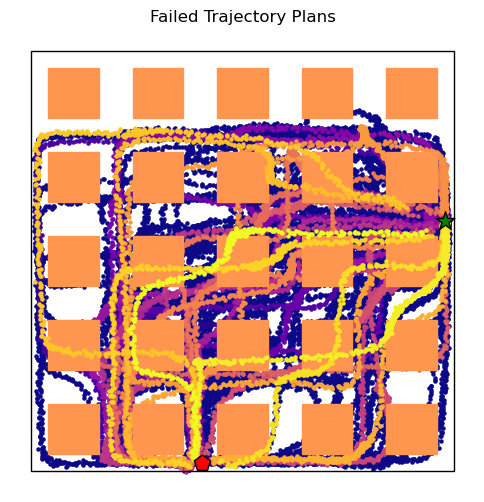

In [24]:
# looking at teailures
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Failed Trajectory Plans')
failed_trajectories = generated_trajectory_visitations - (filtered_trajectories | training_trajectory_visitations)
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in failed_trajectories:
                        ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                        color_index += 1/len(failed_trajectories)
                        

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Environment Info ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.52s/it]


Avg. Completion: 0.0
# of Unique Generated Successful Trajectories: 4
# of New Generated Succesful Trajectories: 0
% of Generated Succesful Trajectories Novel: 0.0
# of Unique Generated Successful Trajectories: 0
# of New Generated Succesful Trajectories: 0


ZeroDivisionError: division by zero

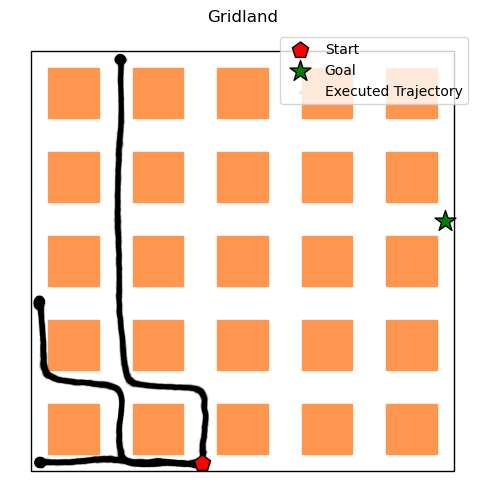

In [12]:
### UNet, CFG
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'cfg'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = False


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
agent.load('trained_models/DP-UNet-CFG-gridland-n5-gc-f0315f21diffusion_ckpt_150000.pt')

# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset(options={'start_idx':start_idx,'goal_idx':goal_idx})
avg_completion,trajectories, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
env = GridLand(n_size=n_size,timeout = 500)
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
#print('replans',np.array(replans).shape)
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
if num_envs == 1:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
else:
        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
#ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
#ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


if num_envs == 1:
        replan_colors = colormaps['plasma_r']
        gradient = np.linspace(0, 1, len(replans[0]))
        for i,replan in enumerate(replans[0]):
                #print(replan.shape)
                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

#print(trajectories[0].shape)
        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
#print(visited_intersections.shape)
        ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=goal_idx)

print('# of Unique Generated Successful Trajectories:',len(generated_trajectory_visitations))
print('# of New Generated Succesful Trajectories:', len(generated_trajectory_visitations-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(generated_trajectory_visitations-training_trajectory_visitations)/len(generated_trajectory_visitations))
print('# of Unique Generated Successful Trajectories:',len(filtered_trajectories))
print('# of New Generated Succesful Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Succesful Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

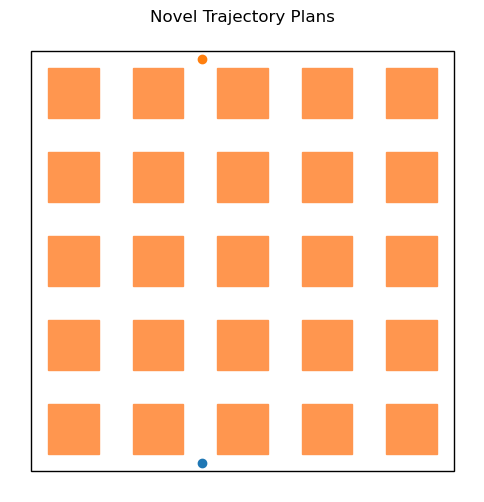

In [14]:
# looking at trajectories and plans for novel ones generated zero shot
env.reset(start_idx=start_idx,goal_idx=goal_idx)
fig, ax = env.get_mpl_plot()
ax.set_title('Novel Trajectory Plans')
novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in novel_trajectories:
                        ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                        color_index += 1/len(novel_trajectories)
                        